In [1]:
import os
import pandas as pd
import seaborn as sns

sns.set()

In [5]:
# fs = "/mnt/weka/home/kyle.chickering/code/nanoGPT/coord-check-impl/2025-08-01_20-14-23"
# fs = "/mnt/weka/home/kyle.chickering/code/nanoGPT/coord-check-impl/584719"
fs = "/mnt/weka/home/kyle.chickering/code/nanoGPT/coord-check-impl/607948"
fs = "/mnt/weka/home/kyle.chickering/code/nanoGPT/coord-check-impl/kyle_kv_impl"
fs = "/mnt/weka/home/kyle.chickering/code/nanoGPT/coord-check-impl/820699" # Head size ablation using xLLM impl
fs = "/mnt/weka/home/kyle.chickering/code/nanoGPT/coord-check-impl/861852" # kv_reps using xllm impl
fs = "/mnt/weka/home/kyle.chickering/code/nanoGPT/coord-check-impl/861873" # kv_reps using kyle impl
fs = "/mnt/weka/home/kyle.chickering/code/nanoGPT/coord-check-impl/862197" # kv_reps using tpv_left_no_kv
# fs = "/mnt/weka/home/kyle.chickering/code/nanoGPT/coord-check-impl/862448" # kv_reps using tpv_left_impl_new_kv_2 with 2 layers
fs = "/mnt/weka/home/kyle.chickering/code/nanoGPT/coord-check-impl/863702" # kv_reps using tpv_left_impl_new_kv_2 with 3 layers
fs = "/mnt/weka/home/kyle.chickering/code/nanoGPT/coord-check-impl/863709" # kv_reps using tpv_left_impl_new_kv_2 with 8 layers
fs = "/mnt/weka/home/kyle.chickering/code/nanoGPT/coord-check-impl/864202" # kv_reps using tpv_left_impl_no_kv with 8 layers
# fs = "/mnt/weka/home/kyle.chickering/code/nanoGPT/coord-check-impl/880936" # kv_reps using tpv_left_impl_no_kv with 8 layers

# fs = "/mnt/weka/home/kyle.chickering/code/nanoGPT/coord-check-impl/868157" # kv_reps kyle impl

# fs = "/mnt/weka/home/kyle.chickering/code/nanoGPT/coord-check-impl/609055"

dfs = []
for root, dirs, files in os.walk(fs):
    for f in files:
        try:
            if ".csv" in f:
                dfs.append(pd.read_csv(os.path.join(root, f)))
        except Exception as e:
            print(f"Error reading {f}: {e}")

df = pd.concat(dfs, ignore_index=True)

df['n_kv_head'] = df['tag'].apply(lambda x: int(x.split(" ")[-1]) if isinstance(x, str) else None)
df['n_embd'] = df['tag'].apply(lambda x: int(x.split(" ")[1]) if isinstance(x, str) else None)

In [6]:
df['n_embd']

0         576
1         576
2         576
3         576
4         576
         ... 
131887    576
131888    576
131889    576
131890    576
131891    576
Name: n_embd, Length: 131892, dtype: int64

Average slope: -1.3525284444445279e-05
Std Dev of slopes: 0.00010853698468921625
Max Abs slope: 0.0006647867115584248


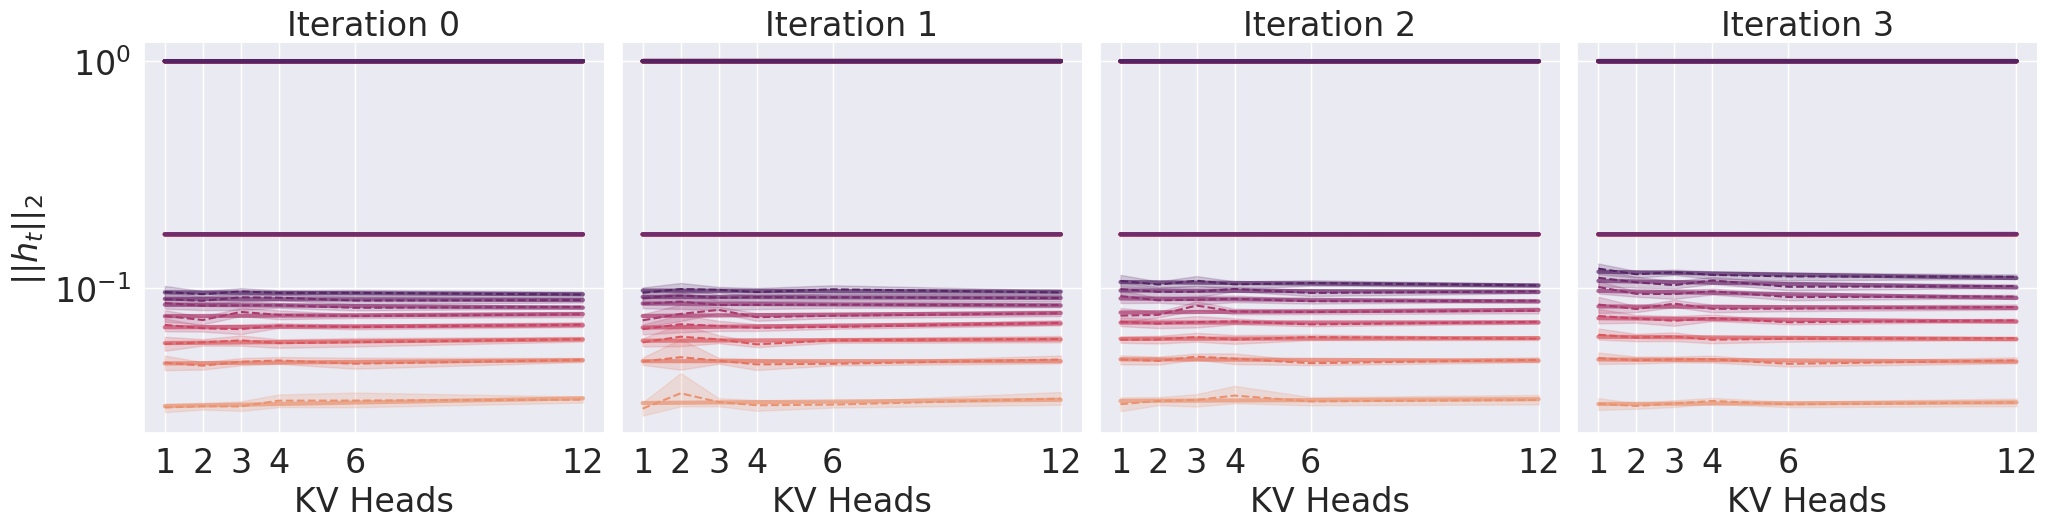

In [9]:
layer_type = "input"
data_type = "norm"

filtered = df[df["fDf"] == "f"]
# filtered = df
filtered = filtered[filtered["layer_type"] == layer_type]
filtered = filtered[filtered["data_type"] == data_type]
filtered = filtered[filtered["iteration"] < 4]
filtered = filtered[filtered["layer"] != "output"]

# ouput_rows = filtered['layer'].str.contains("lm_head")
# filtered.loc[ouput_rows, 'value'] = filtered.loc[ouput_rows, 'value'] / (filtered.loc[ouput_rows, 'width'] / 256)**(1/2)

# lm_head weights are intentionally too big and have a multiplier applied during forward passes
# lm_head_rows = filtered['layer'].str.contains("lm_head")
# filtered.loc[lm_head_rows, 'value'] = filtered.loc[lm_head_rows, 'value'] / filtered.loc[lm_head_rows, 'width']

# # # if layer_type == "input":
# filtered = filtered[filtered['layer'].str.contains("attn.c_proj")]
# # else:
# Apply the computation only to attn.c_kv rows
if layer_type == "weight":
    c_kv_rows = filtered['layer'].str.contains("attn.c_kv")
    filtered.loc[c_kv_rows, 'r'] = (12 / filtered.loc[c_kv_rows, 'n_kv_head'])
    filtered.loc[c_kv_rows, 'value'] = filtered.loc[c_kv_rows, 'value'] / ( (2**(1/2) + filtered.loc[c_kv_rows, 'r']**(1/2)) )

# filtered = filtered[filtered['layer'].str.contains("attn.c_q")]

# attn_c_q_rows = filtered['layer'].str.contains("attn.c_q")
# filtered.loc[attn_c_q_rows, 'value'] = filtered.loc[attn_c_q_rows, 'value'] #* (filtered.loc[attn_c_q_rows, 'width'])

# filtered.loc[:, 'value'] = filtered['value'] * (filtered['width'])**(1/2)

# c_rows = filtered['layer'].str.contains("attn.c_kv")
# filtered.loc[c_rows, 'value'] /= (filtered.loc[c_rows, 'width'] / 256)**(1/3)

# filtered[filtered['layer'].str.contains("c_proj")] *= (filtered[filtered['layer'].str.contains("c_proj")]['width'] / 256)**(1/2)

filtered['n_kv_head'] = filtered['n_kv_head'].astype(int)

drop_cols = ["layer_type", "data_type"]
filtered = filtered.drop(columns=drop_cols)

# Get unique x values for setting ticks
unique_kv_heads = sorted(filtered['n_kv_head'].unique())

p = sns.relplot(
    data=filtered,
    # row="fDf",
    x="n_kv_head",
    y="value",
    hue="layer",
    col="iteration",
    kind="line",
    palette="flare",
    linestyle="--"
)

# Remove the global legend from the relplot
p._legend.remove()

# Plot linear fits for all of the lines using numpy and scipy
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
all_slopes = []
for ax in p.axes.flat:
    for line in ax.get_lines():
        x_data = line.get_xdata()
        y_data = line.get_ydata()
        # Only fit if there are at least 2 unique x values
        if len(set(x_data)) > 1:
            slope, intercept, r_value, p_value, std_err = linregress(x_data, y_data)
            x_fit = np.array([min(x_data), max(x_data)])
            y_fit = intercept + slope * x_fit
            ax.plot(x_fit, y_fit, linestyle='-', linewidth=3.0, color=line.get_color(), alpha=0.7)

            all_slopes.append(slope)

# Apply font size settings and custom labels to all plots
font_size = 24

# Determine y-axis label based on layer_type and data_type
fDf_type = filtered['fDf'].iloc[0] if 'fDf' in filtered.columns else 'f'
if layer_type == "input" and data_type == "norm":
    if fDf_type == "f":
        y_label = r'$||h_t||_2$'
    else:
        y_label = r'$||\Delta h_t||_2$'
elif layer_type == "weight":
    if fDf_type == "f":
        y_label = r'$||W_t||$'
    else:
        y_label = r'$||\Delta W_t||$'
else:
    y_label = "Value"  # fallback

for ax in p.axes.flat:
    ax.tick_params(axis='x', labelsize=font_size)
    ax.tick_params(axis='y', labelsize=font_size)
    ax.set_xlabel('KV Heads', fontsize=font_size)
    ax.set_ylabel(y_label, fontsize=font_size)
    ax.set_title(ax.get_title().replace('iteration = ', 'Iteration '), fontsize=font_size)
    # Set x-axis ticks to only show actual data points
    ax.set_xticks(unique_kv_heads)

print("Average slope:", np.mean(all_slopes))
print("Std Dev of slopes:", np.std(all_slopes))
print("Max Abs slope:", np.max(np.abs(all_slopes)))

# p.set(ylim=[0.0, 0.02])
p.set(yscale='log')
# p.set_axis_labels(
#     "n_kv_heads", 
#     f"{layer_type.capitalize()} {data_type.capitalize()}"
# )

plt.savefig("f_input_norm.pdf", bbox_inches='tight', dpi=300)

<Figure size 640x480 with 0 Axes>

In [35]:
print(len(filtered))

9512


In [36]:
print(df['tag'].unique())
print(len(df['tag'].unique()))

['48 576 12 6' '48 576 12 4' '48 576 12 2' '48 576 12 1' '48 576 12 12'
 '48 576 12 3']
6
